In [1]:
#importando librerias que se piensan utilizar
import numpy as np
import pandas as pd
import seaborn as sns
import re

In [2]:
propiedades = pd.read_csv('properatti.csv', decimal=".")


In [3]:
#renombro columna sin nombre
propiedades.rename(columns={'Unnamed: 0':'id'}, inplace=True)

In [4]:
#Analizamos los datos del evaluador de properati y nos quedamos con los campos 
#ubicacion
#tipo de propiedad
#Ambientes
#Cantidad de baños
#superficie cubierta total
#superficie descubierta total
#cochera y amenities

In [5]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
id                            121220 non-null int64
operation                     121220 non-null object
property_type                 121220 non-null object
place_name                    121197 non-null object
place_with_parent_names       121220 non-null object
country_name                  121220 non-null object
state_name                    121220 non-null object
geonames_id                   102503 non-null float64
lat-lon                       69670 non-null object
lat                           69670 non-null float64
lon                           69670 non-null float64
price                         100810 non-null float64
currency                      100809 non-null object
price_aprox_local_currency    100810 non-null float64
price_aprox_usd               100810 non-null float64
surface_total_in_m2           81892 non-null float64
surface_covered_in_m2         101313 no

In [6]:
#Nos quedamos con las columnas que nos importan 
df_prop = propiedades[["id","place_with_parent_names",
                       "place_name","property_type", 
                       "rooms",
                       "surface_total_in_m2",
                       "surface_covered_in_m2", 
                       "lat-lon",
                       "description",
                       "title",
                       "price",
                       "currency",
                       'price_per_m2',
                       "price_usd_per_m2",
                       'price_aprox_local_currency', 
                       'price_aprox_usd']]

In [7]:
# Verifico duplicados
print('DF sin duplicados:',df_prop.duplicated(subset=None, keep='first').shape)
print('DF Properatti:', df_prop[['place_with_parent_names']].shape)


DF sin duplicados: (121220,)
DF Properatti: (121220, 1)


In [8]:
#Borramos registros con valores duplicadios
df_prop_sin_d = df_prop.drop_duplicates(['place_with_parent_names', 
                          'description', 'title', 
                          'rooms',
                          'surface_total_in_m2'], keep='first')

print('DF Properatti:', df_prop_sin_d[['place_with_parent_names']].shape)

DF Properatti: (111386, 1)


In [9]:
#una vez borrados los duplicados validmos los datos nulos
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66482
surface_total_in_m2           37294
surface_covered_in_m2         18301
lat-lon                       45356
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29593
price_usd_per_m2              47941
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [10]:
df_prop_sin_d.drop([107390,50387,50388], inplace = True)

C:\Users\Lucas\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
df_prop_sin_d['currency'].unique()

array(['USD', nan, 'ARS'], dtype=object)

In [17]:
#llenamos superficie total con superficie cubierta
df_prop_sin_d.fillna({'surface_total_in_m2' : df_prop_sin_d['surface_covered_in_m2']}, inplace = True)

C:\Users\Lucas\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [25]:
#Rellenamos faltantes la variable price usd per m2 cuando hayan datos de precio total y superficie
# recalcular el precio usd por m2 donde este sea null
print(df_prop_sin_d["price_usd_per_m2"].isnull().sum()) # nulos antes
df_prop_sin_d["price_usd_per_m2"] = np.where(df_prop_sin_d["price_usd_per_m2"].isnull(),np.divide(df_prop_sin_d["price_aprox_usd"],df_prop_sin_d["surface_total_in_m2"]),df_prop_sin_d["price_usd_per_m2"])
print(df_prop_sin_d["price_usd_per_m2"].isnull().sum()) # nulos despues

24706
24457


C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
df_prop_sin_d.loc[df_prop_sin_d['price_usd_per_m2'].isna() &
                  (~df_prop_sin_d['price_aprox_usd'].isna())&
                  (~df_prop_sin_d['surface_total_in_m2'].isna())&
                  (df_prop_sin_d['surface_total_in_m2']!=0.),'price_usd_per_m2']= df_prop_sin_d['price_aprox_usd']/df_prop_sin_d['surface_total_in_m2']

C:\Users\Lucas\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
df_prop_sin_d.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         66479
surface_total_in_m2           11755
surface_covered_in_m2         18298
lat-lon                       45353
description                       2
title                             0
price                         17190
currency                      17191
price_per_m2                  29590
price_usd_per_m2              24706
price_aprox_local_currency    17190
price_aprox_usd               17190
dtype: int64

In [35]:
#df_prop_sin_d.drop(price = np.nan)
#df_prop_sin_d.drop([107390,50387,50388], inplace = True)
#df_prod_price = df_prop_sin_d.drop['price'].dropna()
df_prop_price = df_prop_sin_d.dropna(subset=['price'])
df_prop_price.isnull().sum()

id                                0
place_with_parent_names           0
place_name                       23
property_type                     0
rooms                         56361
surface_total_in_m2            7267
surface_covered_in_m2         12398
lat-lon                       38225
description                       2
title                             0
price                             0
currency                          1
price_per_m2                  12400
price_usd_per_m2               7267
price_aprox_local_currency        0
price_aprox_usd                   0
dtype: int64

In [36]:
df_prop_price['place_name'].fillna( value = 'Tigre', inplace = True)

C:\Users\Lucas\Anaconda3\lib\site-packages\pandas\core\generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [38]:
df_prop_price.isnull().sum()

id                                0
place_with_parent_names           0
place_name                        0
property_type                     0
rooms                         56361
surface_total_in_m2            7267
surface_covered_in_m2         12398
lat-lon                       38225
description                       2
title                             0
price                             0
currency                          1
price_per_m2                  12400
price_usd_per_m2               7267
price_aprox_local_currency        0
price_aprox_usd                   0
dtype: int64

ValueError: max must be larger than min in range parameter.

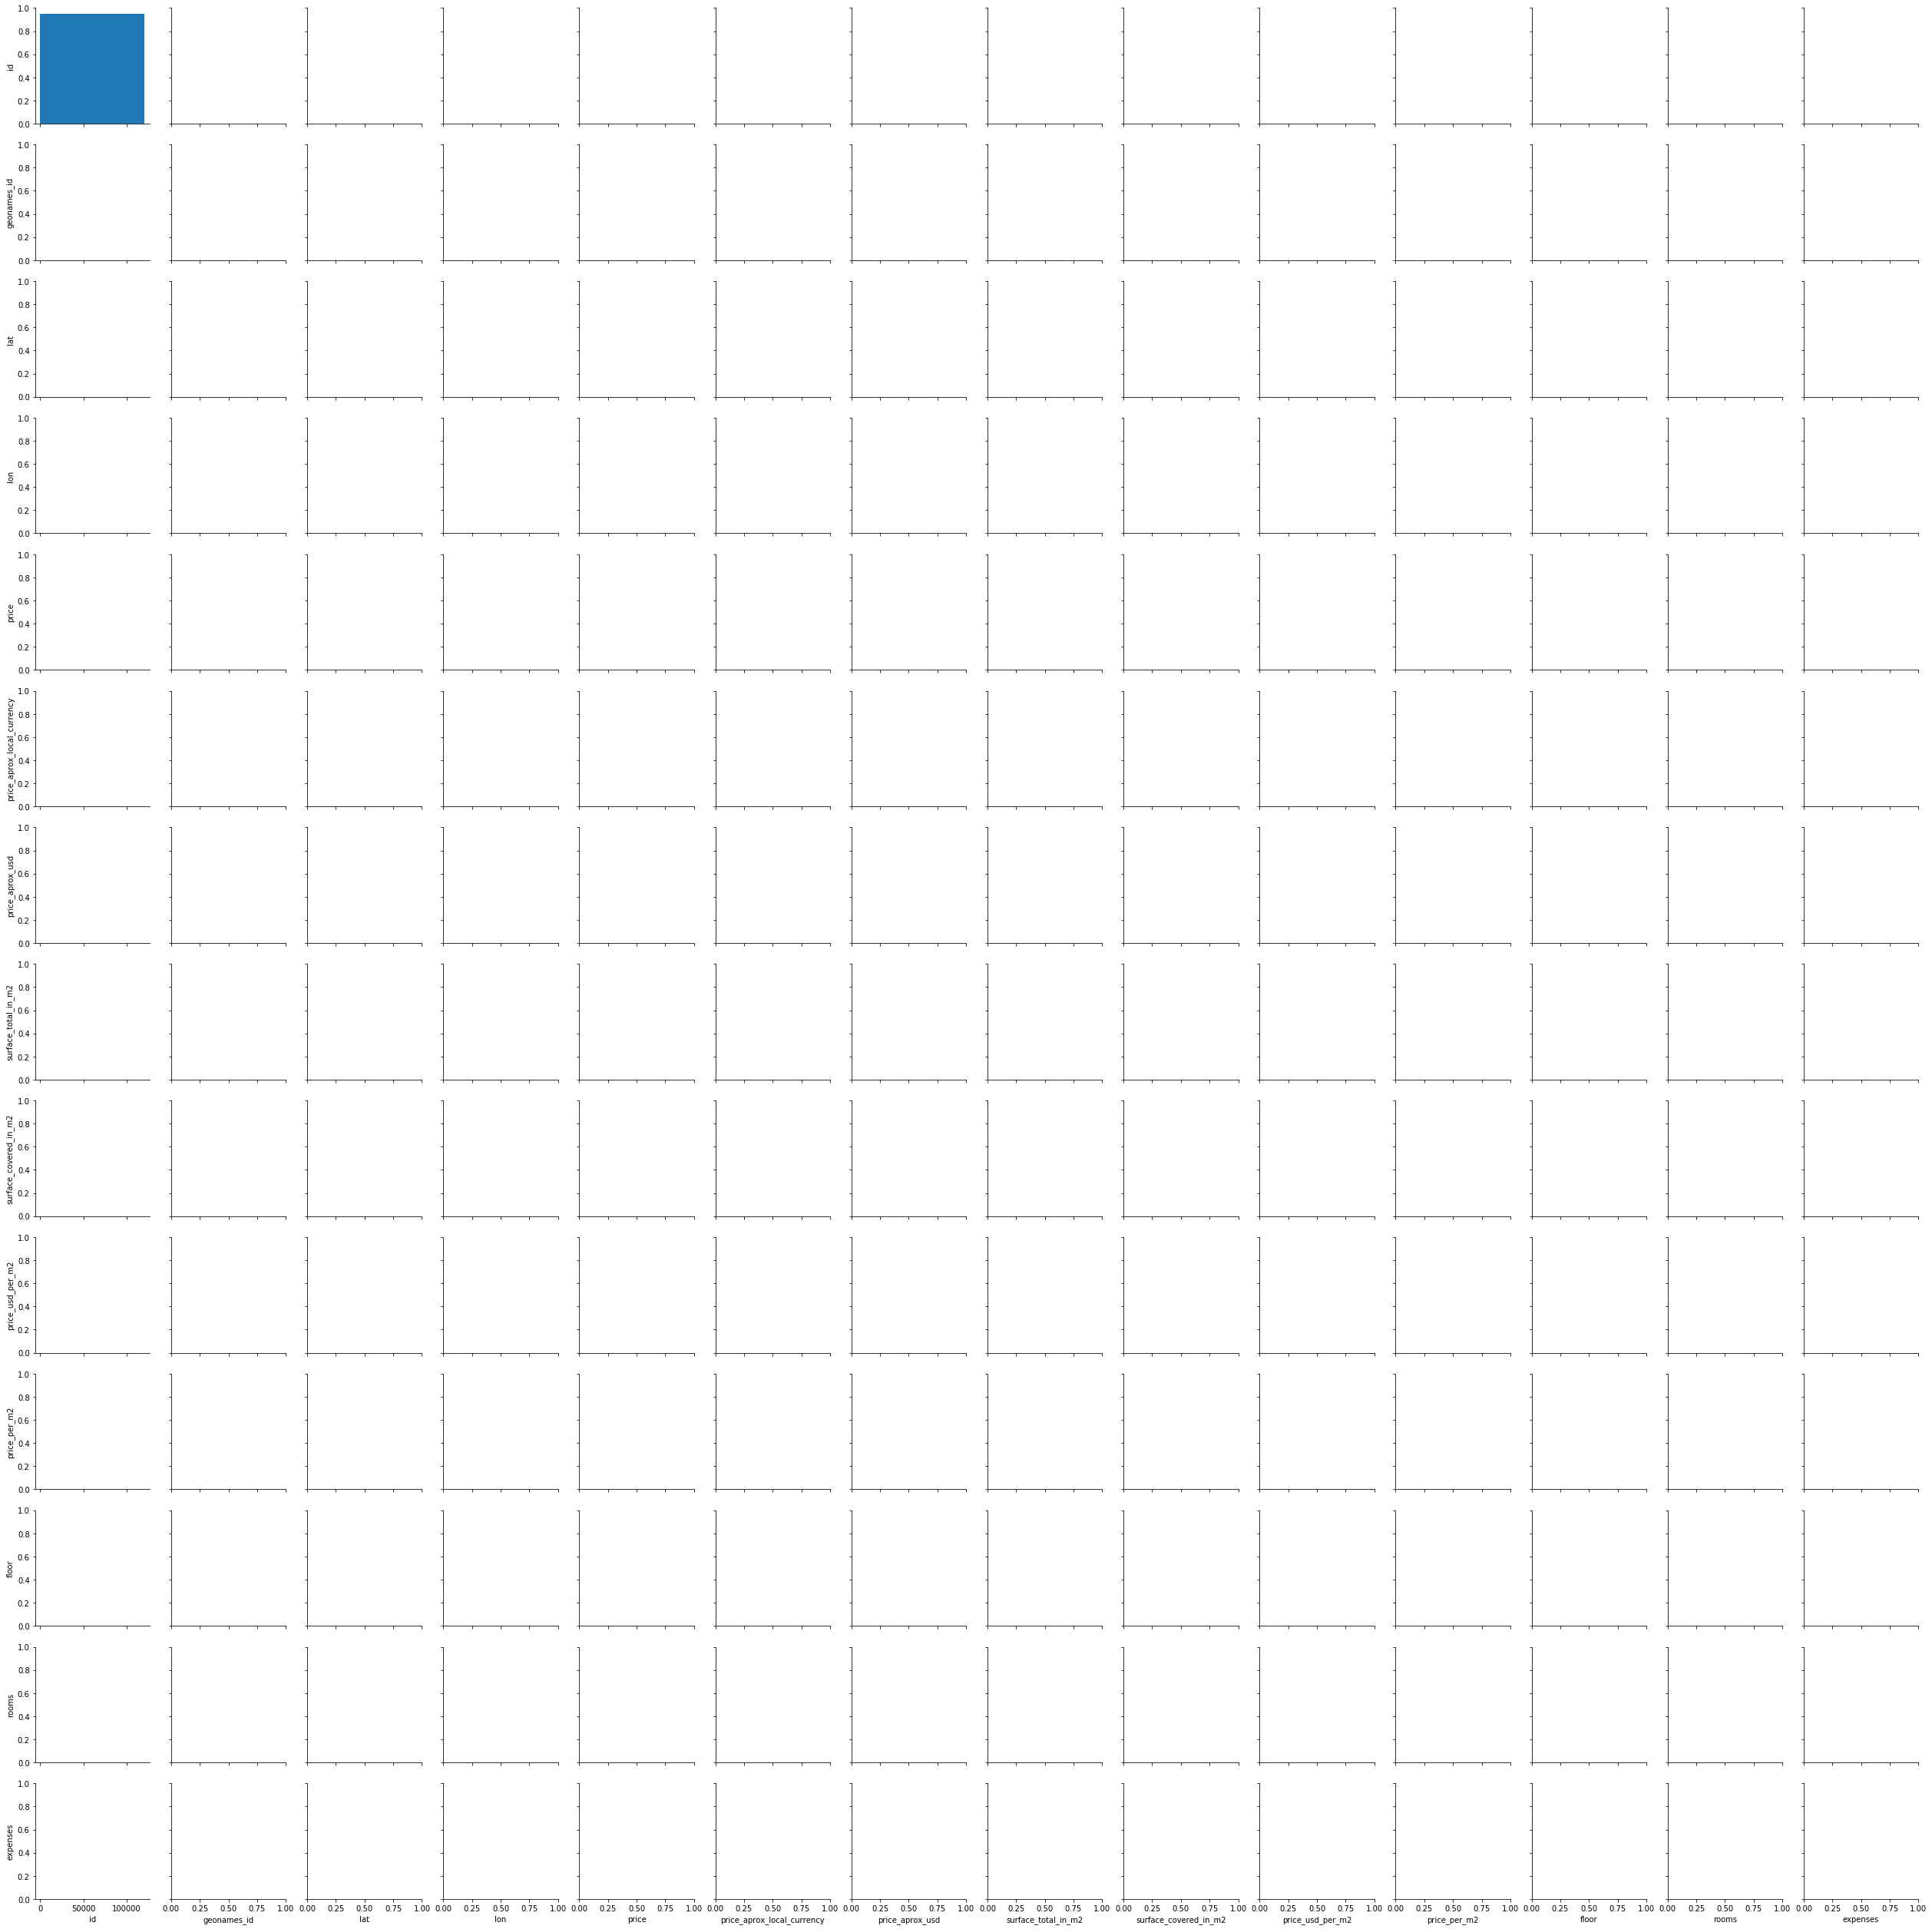

In [39]:
sns.pairplot(propiedades)